<a href="https://colab.research.google.com/github/wlsisl/-/blob/main/YB2%EC%A1%B0_%EB%B0%A9%ED%95%99%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EA%B5%AC%EB%82%B4%EC%8B%9D%EB%8B%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **구내식당 식수 인원 예측 AI 경진대회**

---
## **1. 대회 소개 및 변수 설명**
**[데이콘] 구내식당 식수 인원 예측 AI 경진대회** <br/>
- 빅데이터 분석으로 얻어지는 정확도 높은 예측을 통해 구내식당의 요일별 점심, 저녁식사를 먹는 인원 예측
- 평가산식: MAE (Mean Absolute Error)
- https://dacon.io/competitions/official/235743/overview/rules

**변수 (12개)**
- 일자
- 요일
- 본사정원수
- 본사휴가자수
- 본사출장자수
- 시간외근무명령서승인건수
- 현본사소속재택근무자수
- 조식메뉴
- 중식메뉴
- 석식메뉴
- **중식계**
- **석식계**

## **2. 데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/train.csv')
test=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/test.csv')

**warning 무시 코드**

In [ ]:
import warnings 
warnings.filterwarnings(action='ignore')

**폰트 설치**

In [ ]:
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

In [ ]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [ ]:
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

## **3. 데이터 살펴보기 (EDA)**

#### **점심** 

> **1. 요일과 중식계** <br/>
요일별로 중식계에 얼마나 차이가 생기는지 확인

Text(0.5, 1.0, '요일과 중식계의 관계')

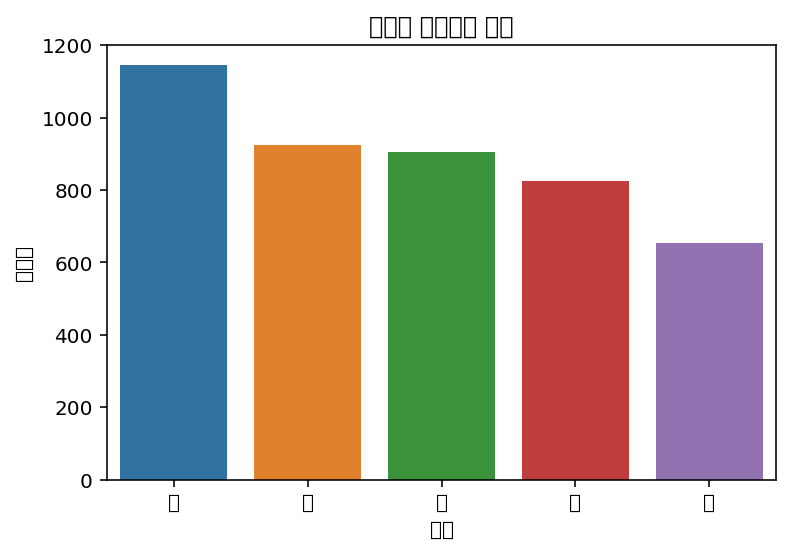

In [ ]:
lunch=train.groupby('요일').mean('중식계')

fig=plt.figure()
axes=fig.add_subplot(1,1,1)

axes=sns.barplot(lunch.index, lunch.중식계, order=['월', '화', '수', '목', '금'])
axes.set_title('요일과 중식계의 관계')

- 월요일에 가장 중식계가 많으며, 금요일로 갈수록 줄어드는 추세를 보임

> **2. 식수가능인원수와 중식계** <br/>
본사정원수에서 본사휴가자수, 본사출장자수, 현본사소속재택근무자수를 제외한 식수가능인원수가 <br/> 중식계와 어떤 관계를 보이는지 확인

In [ ]:
#식수 가능 인원수 = 정원-휴가-출장-재택 와 중식계

train['식수가능인원수']= train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수']

Text(0.5, 1.0, '식수가능인원수와 중식계 관계')

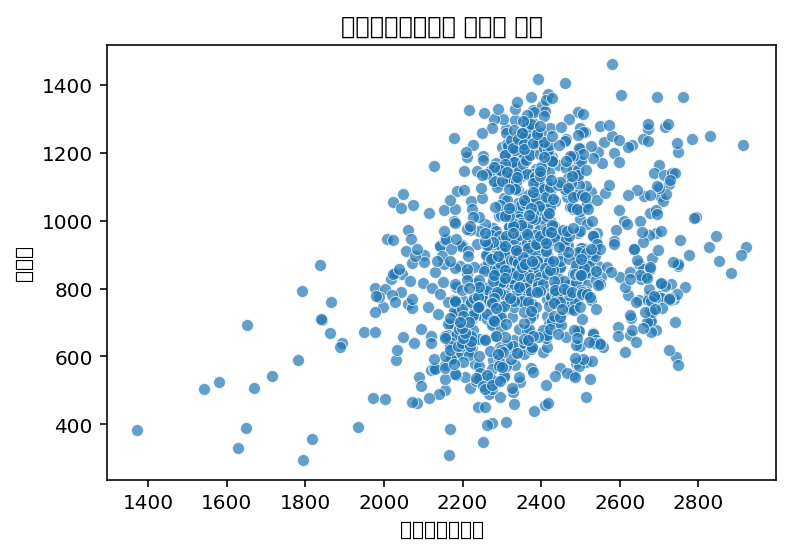

In [ ]:
fig=plt.figure()
graph1=fig.add_subplot(1,1,1)

graph1=sns.scatterplot('식수가능인원수', '중식계', data=train,alpha=0.7)
graph1.set_title('식수가능인원수와 중식계 관계')

- 식수가능인원수가 많은 날일수록 중식계가 높게 나오므로 양의 상관성을 띄고 있음

> **3. 년도별 정원 대비 중식계 비율** <br/>
코로나 이전 (2016-02-01 ~ 2020-01-06)과 코로나 이후 (2020-01-07 ~ 2021-01-26)로 구분지어 확인

In [ ]:
train['일자']=pd.to_datetime(train['일자'])

train['년']=train['일자'].dt.year
train['월']=train['일자'].dt.month
train['일']=train['일자'].dt.day

- '일자' 변수를 datetime type으로 변환 후 년/월/일 변수로 새롭게 생성

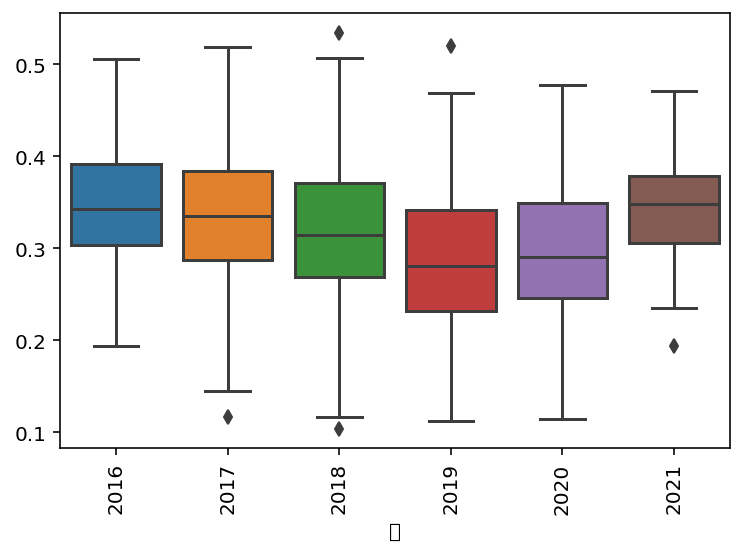

In [ ]:
#년도별 정원 대비 중식계 비율

rot = sns.boxplot(x=train.년 ,y=train.중식계/train.본사정원수)

for item in rot.get_xticklabels():
    item.set_rotation(90)

- 코로나 이전인 2016 ~ 2019년까지는 중식계가 감소하는 추세를 보이다가, 2020년 코로나가 시작되고 오히려 증가
- 코로나로 인해 오히려 직장 내에서 식사를 하는 사람들이 증가한 것으로 추정

#### **저녁** 

> **1. 요일과 석식계** <br/>
요일별로 석식계에 얼마나 차이가 생기는지 확인

Text(0.5, 1.0, '요일과 석식계의 관계')

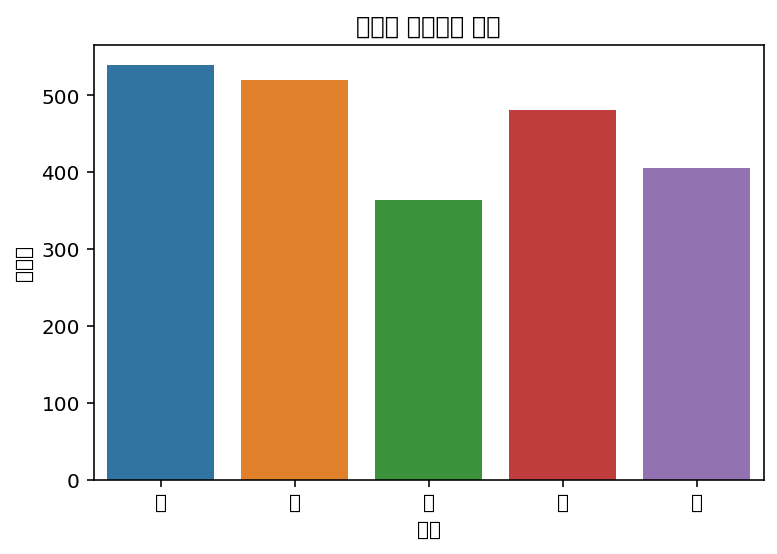

In [ ]:
dinner=train.groupby('요일').mean('석식계')

fig=plt.figure()
axes=fig.add_subplot(1,1,1)

axes=sns.barplot(dinner.index, dinner.석식계, order=['월', '화', '수', '목', '금'])
axes.set_title('요일과 석식계의 관계')

- 월요일에 가장 중식계가 많으며, 수요일과 금요일에 상대적으로 적음
- 비교적 쉬는 일이 많은 수요일과 금요일에는 밖에서 저녁식사를 할 것이라 예상 됨

> **2. 식수가능인원수와 석식계** <br/>
본사정원수에서 본사휴가자수, 본사출장자수, 현본사소속재택근무자수를 제외한 식수가능인원수가 <br/> 석식계와 어떤 관계를 보이는지 확인

Text(0.5, 1.0, '식수가능인원수와 석식계 관계')

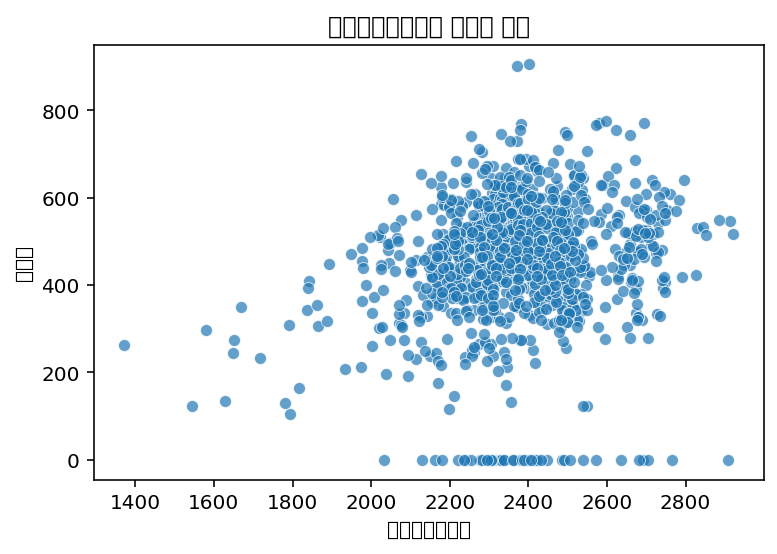

In [ ]:
#식수 가능 인원수 = 정원-휴가-출장-재택 와 석식계
fig=plt.figure()
graph1=fig.add_subplot(1,1,1)

graph1=sns.scatterplot('식수가능인원수', '석식계', data=train,alpha=0.7)
graph1.set_title('식수가능인원수와 석식계 관계')

- 식수가능인원수가 많은 날일수록 석식계가 높게 나오므로 양의 상관성을 띄고 있음

> **3. 년도별 정원 대비 석식계 비율** <br/>
코로나 이전 (2016-02-01 ~ 2020-01-06)과 코로나 이후 (2020-01-07 ~ 2021-01-26)로 구분지어 확인

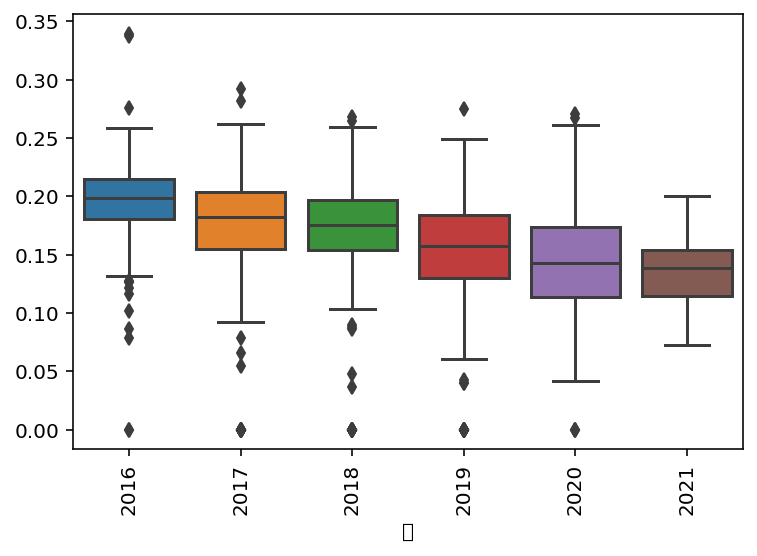

In [ ]:
#년도별 정원 대비 석식계 비율
rot = sns.boxplot(x=train.년 ,y=train.석식계/train.본사정원수)

for item in rot.get_xticklabels():
    item.set_rotation(90)

- 2020년 코로나 발생 이후 정원 대비 석식계 비율은 감소하고 있으나, <br/>
코로나 이전에도 감소하는 추세를 보여왔기 때문에 석식계에 코로나의 영향이 크다고 판단하기 어려움

In [ ]:
#원활한 전처리를 위해 일시적으로 drop
train.drop('식수가능인원수', axis=1, inplace=True)

# **데이터 전처리-중식**

### **< train 데이터 >**


**1.column명 간단하게 바꾸기**

본사정원수 - '정원'

본사휴가자수 - '휴가'

본사출장자수 - '출장'

본사시간외근무명령서승인건수 - '야근'

현본사소속재택근무자수 - '재택'

<식수 가능 인원수,공휴일,계절,날씨 변수 생성>

식수 가능 인원수 = 정원-휴가-출장-재택




In [ ]:
#column명 간단하게 바꾸기
#위에서 datetime해줘버려서 년월일있음.
train.columns=['일자', '요일', '정원', '휴가', '출장', '야근', '재택', '조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계','년','월','일']


**2.일자를 datetime 형식으로 바꾸기** 
 
'일자' column 없애고 year,month,day 칼럼 추가

In [ ]:
#위에서 처리해줌.
train['일자']=pd.to_datetime(train['일자'])

train['년']=train['일자'].dt.year
train['월']=train['일자'].dt.month
train['일']=train['일자'].dt.day

식사가능인원수 생성

In [ ]:
train['식사가능인원수']=train.정원- train.휴가 -train.출장 -train.재택

공휴일 변수 생성

In [ ]:
#공휴일 지정 노가다 (노가다라는 표현말고 좋은 게 있을까요..)
train['공휴일전후'] = 0

train['공휴일전후'][17] = 1
train['공휴일전후'][3] = 1
train['공휴일전후'][62] = 1
# train['공휴일전후'][67] = 1
# train['공휴일전후'][82] = 1
train['공휴일전후'][131] = 1
# train['공휴일전후'][130] = 1
train['공휴일전후'][152] = 1
train['공휴일전후'][226] = 1
train['공휴일전후'][221] = 1
train['공휴일전후'][224] = 1
# train['공휴일전후'][244] = 1
train['공휴일전후'][245] = 1
# train['공휴일전후'][267] = 1
train['공휴일전후'][310] = 1
train['공휴일전후'][311] = 1
train['공휴일전후'][309] = 1
train['공휴일전후'][330] = 1
train['공휴일전후'][379] = 1
train['공휴일전후'][467] = 1
# train['공휴일전후'][469] = 1
train['공휴일전후'][470] = 1
train['공휴일전후'][502] = 1
# train['공휴일전후'][501] = 1
# train['공휴일전후'][511] = 1
train['공휴일전후'][565] = 1
train['공휴일전후'][623] = 1
train['공휴일전후'][651] = 1
# train['공휴일전후'][650] = 1
train['공휴일전후'][705] = 1
# train['공휴일전후'][707] = 1
train['공휴일전후'][709] = 1
# train['공휴일전후'][733] = 1
# train['공휴일전후'][748] = 1
# train['공휴일전후'][792] = 1
train['공휴일전후'][815] = 1
train['공휴일전후'][864] = 1
# train['공휴일전후'][863] = 1
train['공휴일전후'][950] = 1
train['공휴일전후'][951] = 1
train['공휴일전후'][953] = 1
train['공휴일전후'][954] = 1
train['공휴일전후'][955] = 1
train['공휴일전후'][971] = 1
# train['공휴일전후'][970] = 1
# train['공휴일전후'][1037] = 1
train['공휴일전후'][1038] = 1
train['공휴일전후'][1099] = 1
train['공휴일전후'][1129] = 1
# train['공휴일전후'][1128] = 1
train['공휴일전후'][1187] = 1
# train['공휴일전후'][1186] = 1

계절 변수 생성

In [ ]:
#추가) 계절
def transform_season(x) :
    if 3<=x<=5 :
        return '봄'
    elif 6<=x<=8:
        return '여름'
    elif 9<=x<=11 :
        return '가을'
    else :
        return '겨울'

train['월_계절']=train['월'].apply(transform_season)

날씨 데이터 가져오기

In [ ]:
#불러오기
weather=pd.read_table('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/weather.csv', sep=',',encoding='cp949')

In [ ]:
#필요없는 두 칼럼 삭제
weather = weather.iloc[:,2:]

In [ ]:
#nan 0으로 채우기
weather = weather.fillna(0)

In [ ]:
weather['일시']=pd.to_datetime(weather['일시'])
weather['년']=weather['일시'].dt.year
weather['월']=weather['일시'].dt.month
weather['일']=weather['일시'].dt.day

In [ ]:
#merge함수를 씀, 년월일기준으로 일치한 것끼리 데이터프레임병합
train=pd.merge(train,weather,how= 'left', on=['년','월','일'])

#weather에 있던 일시 중복되므로 삭제
train.drop('일시',axis=1,inplace=True)

In [ ]:
train

,일자,요일,정원,휴가,출장,야근,재택,조식메뉴,중식메뉴,석식메뉴,...,월,일,식사가능인원수,공휴일전후,월_계절,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",...,2,1,2401.0,0,겨울,-0.6,-4.1,5.0,0.0,43.9
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",...,2,2,2378.0,0,겨울,-2.3,-9.1,6.2,0.0,47.5
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",...,2,3,2365.0,0,겨울,-1.7,-9.3,7.7,0.0,57.1
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",...,2,4,2277.0,1,겨울,-0.2,-7.7,7.7,0.0,53.4
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",...,2,5,2142.0,0,겨울,1.3,-6.5,9.6,0.0,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,...,1,20,2319.0,0,겨울,-0.4,-9.7,10.6,0.0,64.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,...,1,21,2309.0,0,겨울,5.2,-2.6,12.6,1.7,77.8
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,...,1,22,2177.0,0,겨울,7.0,5.1,9.8,1.2,97.5
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,...,1,25,2396.0,0,겨울,6.3,-1.2,14.3,0.0,75.8


**3.중식계 메뉴명 전처리**



'밥', '국', '반찬1', '반찬2', '반찬3', '후식', '김치', '기타' 순서로 나열

모든 메뉴가 띄어쓰기로 구분되어 나열

메뉴의 원산지가  선택적으로 괄호 안에 표기

- 띄어쓰기 기준으로 메뉴 분리하기 
- 한식 분류법을 이용해 메인메뉴를 분류
- 밥 level 줄이기



1) 띄어쓰기 기준으로 메뉴 분리하기

- 띄어쓰기를 기준으로 분리하여 리스트 형식으로 변경
- 원산지 및 비어있는 값을 삭제

In [ ]:
train.중식메뉴=train.중식메뉴.str.split(' ')

In [ ]:
for j in range(1205):
  menus= train.중식메뉴[j]
  menu_add=train.중식메뉴[j]
  index=[]
  for menu in menus :
    if (':' in menu) or (menu==''):
      menu_add.remove(menu)
  train.중식메뉴[j]=menu_add

원산지 삭제를 위해 괄호 ‘( )’ 를 사용하면 위와 같은 표기로 되어 있는 메뉴가 함께 삭제 되므로 ‘ : ’기호가 포함된 경우를 삭제


---



중식메뉴 리스트에서 밥, 국, 반찬1을 분리하여 개별 변수로 저장

- 중식과 석식을 구분하기 위해 'l_'을 변수명에 붙여줌
- 대부분 반찬1이 메인 메뉴임을 확인할 수 있으므로 메인메뉴로 저장


In [ ]:
bob=[]
for j in range(1205):
  bob.append(train.중식메뉴[j][0])
train['l_bob']=bob

In [ ]:
gug=[]
for j in range(1205):
  gug.append(train.중식메뉴[j][1])
train['l_gug']=gug

In [ ]:
ban_1=[]
for j in range(1205):
  ban_1.append(train.중식메뉴[j][2])
train['l_main']=ban_1

2) 메뉴를 살펴본 결과, 반찬1이 메인메뉴라고 판단

-> 메뉴명을 그대로 이용하기 보다는 한식 분류법을 이용해 메인메뉴를 분류

- 중분류(조리 재료)

**곡류, 두류, 난류, 묵류, 어패류, 육류, 채소류, 해조류, 떡류, 양념 및 장류, 김치류, 만두류, 면류, 과일류**

(스프레드 시트를 이용하여 입력)

- 이때 양념 및 장류, 과일류의 경우 
거의 모든 데이터가 해당하거나 해당하지 않았기 때문에 해당 열은 삭제


---

- 중분류에 해당하는 경우 1, 그 밖의 데이터는 채우지 않았기 때문에 NaN이므로 0으로 대체


In [ ]:
train_l_main=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/lunch_main.csv')
train_l_main = train_l_main.fillna(0)

- 데이터에 포함되어 있는 메뉴명에 해당하는 열을 삭제
- 0과 1로 이루어져 있으므로 int 변수로 형변환

In [ ]:
train_l_main=train_l_main.iloc[:,1:]
train_l_main=train_l_main.astype('int')

In [ ]:
train_l_main.head(5)

,곡류,두류,난류,묵류,어패류,육류,채소류,해조류,떡류,김치류,만두류,면류
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,0



3) 밥 level 줄이기

- 밥 변수는 75개의 level로 이루어져 있어 라벨 인코딩을 진행할 경우 문제가 발생할 수 있음
- 밥, 비빔밥, 카레짜장 등 8개로 변수의 level을 축소



In [ ]:
for i in range(len(train.l_bob)):
  bob=train.l_bob[i]
  if ('쌀밥' in bob) or ('흑미밥' in bob) or ('오곡' in bob)or ('초복' in bob)or ('삼계탕' in bob):
    train.l_bob[i]='밥'
  elif ('비빔밥' in bob ):
    train.l_bob[i]='비빔밥'
  elif ('카레' in bob ) or ('짜장' in bob ):
    train.l_bob[i]='카레짜장'
  elif ('볶음밥' in bob ) or ('필라프' in bob ):
    train.l_bob[i]='볶음밥'
  elif ('덮밥' in bob ):
    train.l_bob[i]='덮밥'
  elif ('곤드레' in bob ) or ('콩나물' in bob ):
    train.l_bob[i]='나물밥'
  elif ('영양밥' in bob ):
    train.l_bob[i]='영양밥'

In [ ]:
train.l_bob.value_counts()

밥        1006
나물밥        61
비빔밥        54
카레짜장       41
덮밥         21
영양밥        12
볶음밥         9
오므라이스       1
Name: l_bob, dtype: int64

**4. 최종 마무리**

초복특식과 같은 경우 메뉴의 순서가 밀려있기 때문에 밥이 메뉴에 있음을 확인 후 분류


# **데이터 전처리-석식**

### **< train 데이터 >**


**1.자기계발의 날 처리**

석식계 0인 행을 지우기 위해 이에 해당하는 행의 index 찾아놓기


In [ ]:
np.where(train.석식계==0)

(array([ 204,  224,  244,  262,  281,  306,  327,  346,  366,  392,  410,
         412,  424,  449,  468,  492,  502,  510,  529,  549,  571,  589,
         609,  633,  648,  667,  687,  706,  730,  747,  766,  786,  809,
         828,  853,  872,  890,  912,  932,  955,  973,  993, 1166]),)


**2.column명 간단하게 바꾸기**

본사정원수 - '정원'

본사휴가자수 - '휴가'

본사출장자수 - '출장'

본사시간외근무명령서승인건수 - '야근'

현본사소속재택근무자수 - '재택'

<식수 가능 인원수 변수 생성>

식수 가능 인원수 = 정원-휴가-출장-재택


**3.일자를 datetime 형식으로 바꾸기**
 
'일자' column 없애고 year,month,day 칼럼 추가


**4.메뉴명 전처리**
(중식메뉴와 동일한 방법 사용)

1) 띄어쓰기 기준으로 메뉴 분리하기
- 띄어쓰기를 기준으로 분리하여 리스트 형식으로 변경
- 원산지 및 비어있는 값을 삭제

In [ ]:
train.석식메뉴=train.석식메뉴.str.split(' ')

In [ ]:
for j in range(1205):
  menus= train.석식메뉴[j]
  menu_add=train.석식메뉴[j]
  for menu in menus :
    if (':' in menu) or (menu==''):
      menu_add.remove(menu)
  train.석식메뉴[j]=menu_add

원산지 삭제를 위해 괄호 ‘( )’ 를 사용하면 위와 같은 표기로 되어 있는 메뉴가 함께 삭제 되므로 ‘ : ’기호가 포함된 경우를 삭제


---



중식메뉴 리스트에서 밥, 국, 반찬1을 분리하여 개별 변수로 저장

- 중식과 석식을 구분하기 위해 'd_'을 변수명에 붙여줌
- 대부분 반찬1이 메인 메뉴임을 확인할 수 있으므로 메인메뉴로 저장


In [ ]:
bob=[]
for j in range(1205):
  bob.append(train.석식메뉴[j][0])
train['d_bob']=bob

In [ ]:
gug=[]
for j in range(1205):
  gug.append(train.석식메뉴[j][1])
train['d_gug']=gug

In [ ]:
ban_1=[]
for j in range(1205):
  ban_1.append(train.석식메뉴[j][2])
train['d_main']=ban_1

2) 메뉴를 살펴본 결과, 반찬1이 메인메뉴라고 판단

-> 메뉴명을 그대로 이용하기 보다는 한식 분류법을 이용해 메인메뉴를 분류

- 중분류(조리 재료)

**곡류, 두류, 난류, 묵류, 어패류, 육류, 채소류, 해조류, 떡류, 양념 및 장류, 김치류, 만두류, 면류, 과일류**

(스프레드 시트를 이용하여 입력)

- 이때 양념 및 장류, 과일류의 경우 
거의 모든 데이터가 해당하거나 해당하지 않았기 때문에 해당 열은 삭제


---

- 중분류에 해당하는 경우 1, 그 밖의 데이터는 채우지 않았기 때문에 NaN이므로 0으로 대체


In [ ]:
train_d_main=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/dinner_main.csv')
train_d_main = train_d_main.fillna(0)

In [ ]:
train_d_main=train_d_main.iloc[:,1:]
train_d_main=train_d_main.astype('int')

In [ ]:
train_d_main.head(5)

,곡류,두류,난류,묵류,어패류,육류,채소류,해조류,떡류,김치류,만두류,면류
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0


3) 밥 level 줄이기


- 석식의 경우 자기계발의 날과 같은 특수한 날은 미운영
- 석식메뉴가 존재함에도 석식계가 0인 데이터의 경우는 오류가 있을 가능성이 있음

=> 석식계가 0인 행의 인덱스를 이용하여 삭제

*
메인메뉴를 중분류한 데이터 프레임도 함께 행을 삭제
이후 데이터 처리에 용이하도록 인덱스 초기화


In [ ]:
train.drop([ 204,  224,  244,  262,  281,  306,  327,  346,  366,  392,  410, 412,  424,  449,  468,  492,  502,  510,  529,  549,  571,  589,
         609,  633,  648,  667,  687,  706,  730,  747,  766,  786,  809,
         828,  853,  872,  890,  912,  932,  955,  973,  993, 1166], axis=0, inplace=True)
train_l_main.drop([ 204,  224,  244,  262,  281,  306,  327,  346,  366,  392,  410, 412,  424,  449,  468,  492,  502,  510,  529,  549,  571,  589,
         609,  633,  648,  667,  687,  706,  730,  747,  766,  786,  809,
         828,  853,  872,  890,  912,  932,  955,  973,  993, 1166], axis=0, inplace=True)
train_d_main.drop([ 204,  224,  244,  262,  281,  306,  327,  346,  366,  392,  410, 412,  424,  449,  468,  492,  502,  510,  529,  549,  571,  589,
         609,  633,  648,  667,  687,  706,  730,  747,  766,  786,  809,
         828,  853,  872,  890,  912,  932,  955,  973,  993, 1166], axis=0, inplace=True)

In [ ]:
train = train.reset_index(drop=True)
train_d_main=train_d_main.reset_index(drop=True)
train_l_main=train_l_main.reset_index(drop=True)

- 중식과 동일한 방식으로 밥 변수 level 정리
- 주먹밥, 초밥김밥 등이 추가되어 약 10가지 이상의 level로 축소 및 구성

In [ ]:
for i in range(len(train.d_bob)):
  bob=train.d_bob[i]
  if ('쌀밥' in bob) or ('흑미밥' in bob) or ('오곡' in bob)or ('초복' in bob)or ('삼계탕' in bob)  or ('작은밥' in bob) or ('추가밥' in bob) or ('＜' in bob):
    train.d_bob[i]='밥'
  elif ('비빔밥' in bob ):
    train.d_bob[i]='비빔밥'
  elif ('카레' in bob ) or ('짜장' in bob ):
    train.d_bob[i]='카레짜장'
  elif ('볶음밥' in bob ) or ('필라프' in bob ):
    train.d_bob[i]='볶음밥'
  elif ('덮밥' in bob ):
    train.d_bob[i]='덮밥'
  elif ('곤드레' in bob ) or ('콩나물' in bob ):
    train.d_bob[i]='나물밥'
  elif ('영양밥' in bob ):
    train.d_bob[i]='영양밥'
  elif ('주먹밥' in bob ):
    train.d_bob[i]='주먹밥'
  elif ('초밥' in bob ) or ('김밥' in bob ):
    train.d_bob[i]='초밥김밥'

=> 추가밥이 포함되어 있어 순서가 뒤바뀌거나 특이한 메뉴가 포함되어 추가적인 처리가 필요


In [ ]:
train.d_bob.value_counts()

밥                 768
볶음밥               119
초밥김밥               85
주먹밥                59
덮밥                 34
카레짜장               31
오므라이스              22
빠에야                10
비빔밥                 8
나물밥                 7
토마토스파게티             3
콩국수                 2
우육비빔냉면              1
마파두부                1
꼬치어묵매운탕             1
(New)케일쌈밥*씨앗쌈장      1
채소라면                1
타워함박스테이크            1
나가사끼짬뽕              1
부채살오므라이스            1
영양밥                 1
투움바스파게티             1
*                   1
옛날왕돈까스              1
나가사키면&김             1
(New)팟시금치무쌉         1
Name: d_bob, dtype: int64

**5. 최종 마무리**

1. 직접 train 원본을 살펴본 후  수정 및 분류
2. 자기 계발의 날의 경우 ‘ * ’로 표시된 경우가 있으므로 행삭제

=> 총 12개의 level로 재분류

In [ ]:
train.d_bob[train.d_bob == '마파두부']='덮밥'
train.d_bob[train.d_bob =='콩국수']= '밥'
train.d_bob[train.d_bob =='타워함박스테이크' ] = '밥'
train.d_bob[train.d_bob =='옛날왕돈까스'] = '밥'
train.d_bob[train.d_bob =='우육비빔냉면'] = '밥'
train.d_bob[train.d_bob =='채소라면'] = '초밥김밥'
train.d_bob[train.d_bob =='나가사끼짬뽕'] = '볶음밥'
train.d_bob[train.d_bob =='나가사키면&김' ] = '주먹밥'
train.d_bob[train.d_bob =='꼬치어묵매운탕'] = '주먹밥'
train.d_bob[train.d_bob =='토마토스파게티'] = '파스타'
train.d_bob[train.d_bob =='투움바스파게티'] = '파스타'
train.d_bob[train.d_bob =='(New)팟시금치무쌉'] = '볶음밥'
train.d_bob[train.d_bob =='(New)케일쌈밥*씨앗쌈장'] = '나물밥'
train.d_bob[train.d_bob =='부채살오므라이스'] = '오므라이스'

In [ ]:
train[train.d_bob=='*'].index

Int64Index([565], dtype='int64')

In [ ]:
train.drop(565, axis=0, inplace=True)
train_l_main.drop(565, axis=0, inplace=True)
train_d_main.drop(565, axis=0, inplace=True)

In [ ]:
train = train.reset_index(drop=True)
train_d_main=train_d_main.reset_index(drop=True)
train_l_main=train_l_main.reset_index(drop=True)

In [ ]:
train.d_bob.value_counts()

밥        773
볶음밥      121
초밥김밥      86
주먹밥       61
덮밥        35
카레짜장      31
오므라이스     23
빠에야       10
나물밥        8
비빔밥        8
파스타        4
영양밥        1
Name: d_bob, dtype: int64

## **< test 데이터 >**

test도 train 과 같은 방식으로 처리


In [ ]:
#column명 간단하게 바꾸기
test.columns = ['일자', '요일', '정원', '휴가', '출장', '야근', '재택', '조식메뉴', '중식메뉴', '석식메뉴']

In [ ]:
test['일자']=pd.to_datetime(test['일자'])
test['년']=test['일자'].dt.year
test['월']=test['일자'].dt.month
test['일']=test['일자'].dt.day

In [ ]:
test['식사가능인원수']=test.정원- test.휴가 -test.출장 -test.재택

In [ ]:
#공휴일데이터
test['공휴일전후'] = 0
test['공휴일전후'][10] =1
test['공휴일전후'][20] = 1

In [ ]:
#계절
test['월_계절']=test['월'].apply(transform_season)

In [ ]:
#weather데이터 년월일기준으로 일치한 것끼리 데이터프레임병합
test=pd.merge(test,weather,how= 'left', on=['년','월','일'])

#weather에 있던 일시 중복되므로 삭제
test.drop('일시',axis=1,inplace=True)

중식 메뉴처리

In [ ]:
test.중식메뉴=test.중식메뉴.str.split(' ')
for j in range(50):
  menus= test.중식메뉴[j]
  menu_add=test.중식메뉴[j]
  index=[]
  for menu in menus :
    if (':' in menu) or (menu==''):
      menu_add.remove(menu)
  test.중식메뉴[j]=menu_add

In [ ]:
bob=[]
for j in range(50):
  bob.append(test.중식메뉴[j][0])
test['l_bob']=bob

석식 메뉴 처리

In [ ]:
test.석식메뉴=test.석식메뉴.str.split(' ')

In [ ]:
bob=[]
for j in range(50):
  bob.append(test.석식메뉴[j][0])
test['d_bob']=bob

In [ ]:
test_l_main=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/test_lunch_main_final.csv')
test_d_main=pd.read_csv('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/test_dinner_main_final.csv')

In [ ]:
test_l_main = test_l_main.fillna(0)
test_d_main = test_d_main.fillna(0)

In [ ]:
test_l_main=test_l_main.iloc[:,1:]
test_l_main=test_l_main.astype('int')
test_d_main=test_d_main.iloc[:,1:]
test_d_main=test_d_main.astype('int')

In [ ]:
for i in range(len(test.l_bob)):
  bob=test.l_bob[i]
  if ('쌀밥' in bob) or ('흑미밥' in bob) or ('오곡' in bob)or ('초복' in bob)or ('삼계탕' in bob):
    test.l_bob[i]='밥'
  elif ('비빔밥' in bob ):
    test.l_bob[i]='비빔밥'
  elif ('카레' in bob ) or ('짜장' in bob ):
    test.l_bob[i]='카레짜장'
  elif ('볶음밥' in bob ) or ('필라프' in bob ):
    test.l_bob[i]='볶음밥'
  elif ('덮밥' in bob ):
    test.l_bob[i]='덮밥'
  elif ('곤드레' in bob ) or ('콩나물' in bob ):
    test.l_bob[i]='나물밥'
  elif ('영양밥' in bob ):
    test.l_bob[i]='영양밥'

In [ ]:
test.l_bob.value_counts()

밥       48
카레짜장     1
비빔밥      1
Name: l_bob, dtype: int64

In [ ]:
for i in range(len(test.d_bob)):
  bob=test.d_bob[i]
  if ('쌀밥' in bob) or ('흑미밥' in bob) or ('오곡' in bob)or ('초복' in bob)or ('삼계탕' in bob)  or ('작은밥' in bob) or ('추가밥' in bob) or ('＜' in bob):
    test.d_bob[i]='밥'
  elif ('비빔밥' in bob ) or ('꽁보리밥' in bob):
    test.d_bob[i]='비빔밥'
  elif ('카레' in bob ) or ('짜장' in bob ):
    test.d_bob[i]='카레짜장'
  elif ('볶음밥' in bob ) or ('필라프' in bob ):
    test.d_bob[i]='볶음밥'
  elif ('덮밥' in bob ):
    test.d_bob[i]='덮밥'
  elif ('곤드레' in bob ) or ('콩나물' in bob ):
    test.d_bob[i]='나물밥'
  elif ('영양밥' in bob ):
    test.d_bob[i]='영양밥'
  elif ('주먹밥' in bob ):
    test.d_bob[i]='주먹밥'
  elif ('초밥' in bob ) or ('김밥' in bob ):
    test.d_bob[i]='초밥김밥'

In [ ]:
test.d_bob.value_counts()

밥        39
초밥김밥      3
카레짜장      3
오므라이스     1
나물밥       1
비빔밥       1
덮밥        1
볶음밥       1
Name: d_bob, dtype: int64

# **train test 최종 형태**

필요없는 변수 삭제 및 확인

In [ ]:
train.drop(['일','일자','조식메뉴','중식메뉴','석식메뉴','l_gug','l_main','d_gug', 'd_main'],axis=1,inplace=True)
test.drop(['일','일자','조식메뉴','중식메뉴','석식메뉴'],axis=1,inplace=True)

In [ ]:
train.head(5)

,요일,정원,휴가,출장,야근,재택,중식계,석식계,년,월,식사가능인원수,공휴일전후,월_계절,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%),l_bob,d_bob
0,월,2601,50,150,238,0.0,1039.0,331.0,2016,2,2401.0,0,겨울,-0.6,-4.1,5.0,0.0,43.9,밥,밥
1,화,2601,50,173,319,0.0,867.0,560.0,2016,2,2378.0,0,겨울,-2.3,-9.1,6.2,0.0,47.5,밥,나물밥
2,수,2601,56,180,111,0.0,1017.0,573.0,2016,2,2365.0,0,겨울,-1.7,-9.3,7.7,0.0,57.1,카레짜장,밥
3,목,2601,104,220,355,0.0,978.0,525.0,2016,2,2277.0,1,겨울,-0.2,-7.7,7.7,0.0,53.4,밥,초밥김밥
4,금,2601,278,181,34,0.0,925.0,330.0,2016,2,2142.0,0,겨울,1.3,-6.5,9.6,0.0,44.4,밥,밥


In [ ]:
test.head(5)

,요일,정원,휴가,출장,야근,재택,년,월,식사가능인원수,공휴일전후,월_계절,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%),l_bob,d_bob
0,수,2983,88,182,5,358.0,2021,1,2355.0,0,겨울,4.1,-1.2,11.4,0.0,61.5,밥,밥
1,목,2983,104,212,409,348.0,2021,1,2319.0,0,겨울,1.4,-3.0,10.7,0.0,58.1,밥,초밥김밥
2,금,2983,270,249,0,294.0,2021,1,2170.0,0,겨울,-2.3,-6.0,3.0,0.0,39.4,밥,밥
3,월,2924,108,154,538,322.0,2021,2,2340.0,0,겨울,7.5,4.3,10.6,16.0,84.5,밥,밥
4,화,2924,62,186,455,314.0,2021,2,2362.0,0,겨울,0.4,-5.2,7.5,0.0,36.0,밥,밥


## **l_train, l_test**
**중식계 예측에 사용할 데이터 분리**

In [ ]:
l_train=train.drop(['석식계', 'd_bob'], axis=1)
l_X=pd.concat([l_train.drop('중식계',axis=1), train_l_main], axis=1)
l_y=l_train.중식계

In [ ]:
l_test=pd.concat([test.drop(['d_bob'], axis=1), test_l_main], axis=1)

## **d_train, d_test**
**석식계 예측에 사용할 데이터 분리**

In [ ]:
d_train=train.drop(['중식계', 'l_bob'], axis=1)
d_X=pd.concat([d_train.drop(['석식계','식사가능인원수'],axis=1), train_d_main], axis=1)
d_y=d_train.석식계

In [ ]:
d_test=pd.concat([test.drop(['l_bob','식사가능인원수'], axis=1), test_d_main], axis=1)

# **인코딩**

전처리 완료한 최종 데이터 형태에서 인코딩이 필요한 피처는 요일, 계절, 밥.

train, test 데이터 모두 해당 피처에 대해 라벨인코딩 적용.

In [ ]:
#요일 피처에 라벨 인코딩 적용
le=LabelEncoder()
l_X.요일=le.fit_transform(l_X.요일)
l_test.요일=le.transform(l_test.요일)
l_train.요일=le.transform(l_train.요일)

le=LabelEncoder()
d_X.요일=le.fit_transform(d_X.요일)
d_test.요일=le.transform(d_test.요일)
d_train.요일=le.transform(d_train.요일)

In [ ]:
#l_bob 피처에 라벨 인코딩 적용
le=LabelEncoder()
l_X.l_bob=le.fit_transform(l_X.l_bob)
l_test.l_bob=le.transform(l_test.l_bob)
l_train.l_bob=le.transform(l_train.l_bob)

#d_bob 피처에 라벨 인코딩 적용
le=LabelEncoder()
d_X.d_bob=le.fit_transform(d_X.d_bob)
d_test.d_bob=le.transform(d_test.d_bob)
d_train.d_bob=le.transform(d_train.d_bob)

In [ ]:
#계절 피처에 라벨 인코딩 적용
le=LabelEncoder()
l_X.월_계절=le.fit_transform(l_X.월_계절)
l_test.월_계절=le.transform(l_test.월_계절)
l_train.월_계절=le.transform(l_train.월_계절)

le=LabelEncoder()
d_X.월_계절=le.fit_transform(d_X.월_계절)
d_test.월_계절=le.transform(d_test.월_계절)
d_train.월_계절=le.transform(d_train.월_계절)

In [ ]:
l_X.head(3)

,요일,정원,휴가,출장,야근,재택,년,월,식사가능인원수,공휴일전후,...,난류,묵류,어패류,육류,채소류,해조류,떡류,김치류,만두류,면류
0,3,2601,50,150,238,0.0,2016,2,2401.0,0,...,0,0,0,1,0,0,0,0,0,0
1,4,2601,50,173,319,0.0,2016,2,2378.0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,2601,56,180,111,0.0,2016,2,2365.0,0,...,0,0,0,1,0,0,0,0,0,0


라벨 인코딩 결과 아래와 같이 모든 피처들이 숫자형으로 변환됨.

In [ ]:
l_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   요일          1161 non-null   int64  
 1   정원          1161 non-null   int64  
 2   휴가          1161 non-null   int64  
 3   출장          1161 non-null   int64  
 4   야근          1161 non-null   int64  
 5   재택          1161 non-null   float64
 6   년           1161 non-null   int64  
 7   월           1161 non-null   int64  
 8   식사가능인원수     1161 non-null   float64
 9   공휴일전후       1161 non-null   int64  
 10  월_계절        1161 non-null   int64  
 11  평균기온(°C)    1161 non-null   float64
 12  최저기온(°C)    1161 non-null   float64
 13  최고기온(°C)    1161 non-null   float64
 14  일강수량(mm)    1161 non-null   float64
 15  평균 상대습도(%)  1161 non-null   float64
 16  l_bob       1161 non-null   int64  
 17  곡류          1161 non-null   int64  
 18  두류          1161 non-null   int64  
 19  난류          1161 non-null  

In [ ]:
d_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   요일          1161 non-null   int64  
 1   정원          1161 non-null   int64  
 2   휴가          1161 non-null   int64  
 3   출장          1161 non-null   int64  
 4   야근          1161 non-null   int64  
 5   재택          1161 non-null   float64
 6   년           1161 non-null   int64  
 7   월           1161 non-null   int64  
 8   공휴일전후       1161 non-null   int64  
 9   월_계절        1161 non-null   int64  
 10  평균기온(°C)    1161 non-null   float64
 11  최저기온(°C)    1161 non-null   float64
 12  최고기온(°C)    1161 non-null   float64
 13  일강수량(mm)    1161 non-null   float64
 14  평균 상대습도(%)  1161 non-null   float64
 15  d_bob       1161 non-null   int64  
 16  곡류          1161 non-null   int64  
 17  두류          1161 non-null   int64  
 18  난류          1161 non-null   int64  
 19  묵류          1161 non-null  

# **모델링**

다양한 모델링을 적용했으나 xgboost와 lgbm의 혼합 형태의 점수가 가장 좋았기에 xgboost와 lgbm의 혼합 형태로 최종 모델링 진행.

>**<중식계 예측>**

모델링 성능 향상을 위해 하이퍼 파라미터 조정

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit( l_X, l_y)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

#xgboost 회귀 트리
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[0, 0.1 ,10,100,200,250,300]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

#ligthgbm 회귀 트리
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[0, 0.1 ,10,100,200,250,300]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

하이퍼 파라마터 조정 결과, 중식계 예측 시 XGBRegressor는 n_estimators가 250일 때, LGBMRegressor가 300일 때 가장 뛰어남.

조정된 하이퍼 파라미터를 적용한 두 모델을 9대 1로 혼합해 성능 향상.

In [ ]:
#  XGBoost 와 lightGBM을 혼합
xgb_reg = XGBRegressor(n_estimators=250, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit( l_X, l_y)
lgbm_reg.fit( l_X, l_y)
xgb_pred_ln = xgb_reg.predict(l_test)
lgbm_pred_ln = lgbm_reg.predict( l_test)

pred_ln = 0.9 * xgb_pred_ln + 0.1 * lgbm_pred_ln
preds_ln = {'최종 혼합': pred_ln,
         'XGBM': xgb_pred_ln,
         'LGBM': lgbm_pred_ln}


[16:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


>**<석식계 예측>**

중식계 예측과 마찬가지로, 하이퍼 파라미터 조정 과정을 먼저 거침.

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit( d_X, d_y)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

#xgboost 회귀 트리
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[0, 0.1 ,10,100,200,250,300]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

#ligthgbm 회귀 트리
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[0, 0.1 ,10,100,200,250,300]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[16:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:54:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:55:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

하이퍼 파라마터 조정 결과, 석식계 예측 시에는 XGBRegressor와 LGBMRegressor의 n_estimators가 모두 300일 때 가장 뛰어남.

조정된 하이퍼 파라미터를 적용한 두 모델을 9대 1로 혼합해 성능 향상.

In [ ]:
#  XGBoost 와 lightGBM을 혼합
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit( d_X, d_y)
lgbm_reg.fit( d_X, d_y)
xgb_pred_dn = xgb_reg.predict(d_test)
lgbm_pred_dn = lgbm_reg.predict(d_test)

pred_dn = 0.9 * xgb_pred_dn + 0.1 * lgbm_pred_dn
preds_dn = {'최종 혼합': pred_dn,
         'XGBM': xgb_pred_dn,
         'LGBM': lgbm_pred_dn}

[16:55:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
submission= pd.read_table('/content/drive/MyDrive/YB_2조/23년 1월 프로젝트/sample_submission.csv',sep=',')

submission['중식계'] = pred_ln
submission['석식계'] = pred_dn
submission.to_csv('submission_최종.csv', index = False)

# **결과**

xgboost와 lgbm을 혼합했을 때 78.43점으로 점수가 가장 좋았음.

그 외에는 모델링에 pyaret 적용 시 84점, catboost 적용 시 85점이 나옴.